# Load data and library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from string import punctuation
import re

df_raw = pd.read_csv("utterance-channel-dataset.csv")

# EDA

In [27]:
set(df_raw['Channel'])

{'General',
 'Introduction',
 'Off-topic',
 'Resources',
 'Resume Review',
 'community-requests',
 'general-questions',
 'member-generated-content'}

In [7]:
df_raw

,Utterance,Channel,ID
0,Separate Category for the Weekly Topic To bett...,community-requests,1
1,"hey, i would like to ask if it's possible to g...",community-requests,2
2,Any update on my ModMail about the hackathon?,community-requests,3
3,@Admins I have a suggestion. Python has some m...,community-requests,4
4,Can we have a beginner channel,community-requests,5
...,...,...,...
295,"Thanks @antonai , will underline the keywords",Resume Review,296
296,Thanks for sharing @frazali52 i will get to th...,Resume Review,297
297,Thanks for sharing your resume Faraz. It looks...,Resume Review,298
298,"yes of course, just delete any address, phone ...",Resume Review,299


In [8]:
df_raw['Utterance']
cv = CountVectorizer()
word_count = cv.fit_transform(df_raw['Utterance'])
df_word_ct = pd.DataFrame.sparse.from_spmatrix(word_count, columns= cv.get_feature_names())

### Remove stop words

In [5]:
customStopWords = set(stopwords.words('english')+list(punctuation))
ls_remove = ['?', 'how','what','when','who','why']
customStopWords.difference_update(ls_remove)

wnl = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

In [10]:
def cleanText(text):
    df_word_cleaned = []
    for i in range(len(text)):
        new_sent = re.sub(r'\d+', '', text.iloc[i]).lower() #remove numbers
        new_sent = re.sub(r'http\S+', '', new_sent) # remove url
        wordtokenList = [word for word in word_tokenize(new_sent)]
        wordNoStopList = [word for word in wordtokenList if word not in customStopWords]
        lemList = [wnl.lemmatize(word) for word in wordNoStopList]
        df_word_cleaned.append([porter_stemmer.stem(word) for word in lemList])
    # re-assemble the token back to sentence form 
    cleaned_sent = []
    for sentence in df_word_cleaned:
        cleaned_sent.append(TreebankWordDetokenizer().detokenize(sentence))
    cleaned_sent
    
    return cleaned_sent


### Get TF

In [12]:
cv = CountVectorizer()
tf = cv.fit_transform(cleaned_sent)
df_tf = pd.DataFrame.sparse.from_spmatrix(tf, columns= cv.get_feature_names())#.to_csv("tf.csv")
df_tf

### Get TF-IDF

In [29]:
vectorizer = TfidfVectorizer(min_df = 3,ngram_range = (1,3))
transformed_documents = vectorizer.fit_transform(df_raw['Utterance'])
# transformed_documents = vectorizer.fit_transform(cleanText(df_raw['Utterance']))
df_transform_documents = pd.DataFrame.sparse.from_spmatrix(transformed_documents, columns=vectorizer.get_feature_names())#.to_csv('cleanedminTF3ng3.csv')
df_transform_documents

,10,2021,able,able to,about,about ai,actually,add,adding,advanced,...,you guys,you have,you re,you recommend,you should,you think,you to,you want,your,your resume
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.347712,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
297,0.0,0.0,0.0,0.0,0.026514,0.0,0.0,0.078043,0.04224,0.0,...,0.0,0.167594,0.107408,0.0,0.0,0.040469,0.0,0.0,0.304612,0.183688
298,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [30]:
# This cannot replace 0 with nan due to "pd.DataFrame.sparse.from_spmatrix" stored columns as sparse matrix
df_transform_documents.mean(axis=0)#.sort_values(ascending=False)[0:60]


10             0.003264
2021           0.004097
able           0.001416
able to        0.001416
about          0.013907
                 ...   
you think      0.002372
you to         0.001870
you want       0.002660
your           0.018666
your resume    0.004428
Length: 756, dtype: float64

In [50]:
df_tfidf.replace(0, np.NaN).mean(axis=0).sort_values(ascending=False)

showusyourdog    1.000000
lmao             1.000000
bahaha           1.000000
showmeyourdog    1.000000
breakthrough     0.890691
                   ...   
mile             0.045750
creative         0.045750
definitely       0.044400
looks            0.044400
faraz            0.044400
Length: 2060, dtype: float64

In [31]:
vectorizer2 = TfidfVectorizer(stop_words='english')
transformed_documents2 = vectorizer2.fit_transform(df_raw['Utterance'])

In [32]:
len(vectorizer.get_feature_names())

756

### TF-IDF using cleaned text

In [24]:
vectorizer = TfidfVectorizer(min_df = 3,ngram_range = (1,3))
transformed_documents = vectorizer.fit_transform(cleaned_sent)

In [26]:
df_transform_document = pd.DataFrame.sparse.from_spmatrix(transformed_documents,columns=vectorizer.get_feature_names())
df_transform_document#.to_csv('Cleaned TFIDF.csv')

,abl,actual,ad,add,addit,address,admin,advanc,advic,agre,...,work,would,would like,write,written,wrote,yacov,ye,year,yet
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.252394,0.36034,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.291326,0.0,0.0,0.0,...,0.000000,0.177472,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
296,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
297,0.0,0.0,0.070396,0.135757,0.073478,0.000000,0.000000,0.0,0.0,0.0,...,0.151735,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
298,0.0,0.0,0.000000,0.000000,0.000000,0.483349,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.463078,0.0,0.0


# Modeling

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df_raw, df_raw['Channel'], test_size=0.1, random_state=42)

In [36]:
vectorizer = TfidfVectorizer(min_df = 3, max_df = 0.6, ngram_range = (1,3))

In [37]:
clf = SVC()

In [39]:
transformed_documents = vectorizer.fit_transform(X_train['Utterance'])
df_transform_documents = pd.DataFrame.sparse.from_spmatrix(transformed_documents,columns=vectorizer.get_feature_names())

scores = cross_val_score(clf, df_transform_documents.values, y_train, cv=10, n_jobs=-1,scoring='accuracy')

In [40]:
scores

array([0.48148148, 0.59259259, 0.48148148, 0.55555556, 0.55555556,
       0.74074074, 0.51851852, 0.59259259, 0.62962963, 0.66666667])

In [42]:
transformed_documents

<270x673 sparse matrix of type '<class 'numpy.float64'>'
	with 5576 stored elements in Compressed Sparse Row format>

In [43]:
clf.fit(transformed_documents,y_train)
print("Trainning", clf.score(transformed_documents,y_train))

0.9888888888888889

In [45]:
test_transfomend = vectorizer.transform(X_test['Utterance'])

In [49]:
print(clf.score(test_transfomend,y_test))

0.7

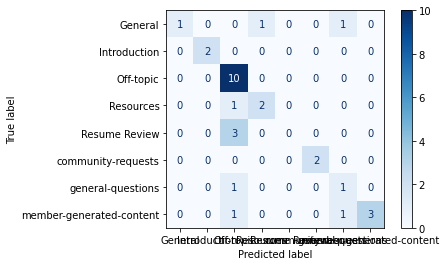

In [52]:
plot_confusion_matrix(clf, test_transfomend, y_test, cmap=plt.cm.Blues)  

### Test cleaned tf-idf

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    df_raw['Utterance'], df_raw['Channel'], test_size=0.2, random_state=42)

In [55]:
X_train

232                                       shOWUSYOURDOG.
59     Please keep this channel only for information ...
6      FAQ Update We've updated the Frequently Asked ...
185               Open a command prompt as administrator
173    Scikit-Learn Design with Easy Explanation I th...
                             ...                        
188    @Poppa isn't there a Finnish saying about, "if...
71              does anyone has any experience with mds?
106    Hei anuj, It seems we have same background. Ca...
270            what are good resources for learning nlp?
102    Something pretty like this one from the ResNet...
Name: Utterance, Length: 240, dtype: object

In [58]:
# X_train = cleanText(X_train)
vectorizer = TfidfVectorizer(min_df = 3, ngram_range = (1,3))
transformed_documents = vectorizer.fit_transform(X_train)

In [59]:
df_transform_document = pd.DataFrame.sparse.from_spmatrix(transformed_documents,columns=vectorizer.get_feature_names())

In [60]:
df_transform_document

,10,able,able to,about,about ai,actually,add,after,again,agree,...,you can,you do,you guys,you have,you re,you recommend,you to,you want,your,your resume
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.137601,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.262595,0.0,0.0,0.0,0.274614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.0,0.290775,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
test_transfomend

<30x673 sparse matrix of type '<class 'numpy.float64'>'
	with 444 stored elements in Compressed Sparse Row format>

In [62]:
X_test = cleanText(X_test)
test_transfomend = vectorizer.transform(X_test)

In [63]:
clf = SVC(C=1)
clf.fit(transformed_documents,y_train)

SVC(C=1)

In [64]:
clf.score(transformed_documents,y_train)

0.9916666666666667

In [65]:
clf.score(test_transfomend,y_test)

0.4166666666666667

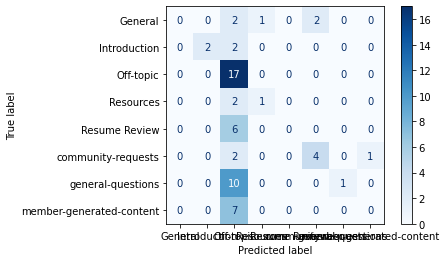

In [67]:
plot_confusion_matrix(clf, test_transfomend, y_test, cmap=plt.cm.Blues)  

In [68]:


print(classification_report(y_test, clf.predict(test_transfomend)))

                          precision    recall  f1-score   support

                 General       0.00      0.00      0.00         5
            Introduction       1.00      0.50      0.67         4
               Off-topic       0.35      1.00      0.52        17
               Resources       0.50      0.33      0.40         3
           Resume Review       0.00      0.00      0.00         6
      community-requests       0.67      0.57      0.62         7
       general-questions       1.00      0.09      0.17        11
member-generated-content       0.00      0.00      0.00         7

                accuracy                           0.42        60
               macro avg       0.44      0.31      0.30        60
            weighted avg       0.45      0.42      0.32        60



D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [227]:
confusion_matrix(y_test, clf.predict(test_transfomend)).ravel().reshape([8,8])

array([[ 2,  0,  1,  1,  0,  1,  0,  0],
       [ 0,  3,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0,  2,  1],
       [ 0,  0,  0,  3,  0,  0,  0,  0],
       [ 0,  0,  2,  1,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  7,  0,  0],
       [ 0,  0,  8,  0,  0,  0,  3,  0],
       [ 0,  0,  1,  1,  0,  0,  1,  4]], dtype=int64)

## Pipeline and Utility Function

In [23]:

pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

parameters = {
#     'preprocessor':[],
#     'stop_words':[],
    'tfidf__ngram_range':[(1,1),(1,2),(1,3)],
    'tfidf__max_df':[1,.9,.8,.7,.6],
    'tfidf__min_df':[1,2,3,4,5],
#     'max_features':[],
    'svc__C':[1,.9,.7,.5,.2,.1],
    
}

# grid search
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
df_raw = pd.read_csv("utterance-channel-dataset.csv")
X_train, X_test, y_train, y_test = train_test_split(
    df_raw['Utterance'], df_raw['Channel'], test_size=0.1, random_state=42)

grid_search.fit(X_train,y_train)

grid_search.best_score_